In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
merge = pd.read_csv("Latest_all_in_one.csv")
merge.head()

,RID,Sleep_Apnea,Restless_Legs,Insomnia,Sleep_Disturbance_Other,RightEntorhinal,RightTemporalPole,RightParahippocampal,RightInferiorTemporal,RightMiddleTemporal,...,Adjusted_Age,MH,NPIK,NPIKSEV,BMI,ADNI_MEM,ADNI_EF,ADNI_VS,ADNI_LAN,ADNI_EF2
0,3,0,0,0,0,791.846918,1078.037276,1512.146246,6716.630454,8350.166431,...,81.300000,1,0.0,0.0,10.927769,-1.021,-1.144,-0.880,-1.368,-1.062
1,3,0,0,0,0,958.133790,938.695742,1614.977833,6975.019609,7541.152761,...,81.798289,1,0.0,0.0,10.927769,-1.187,-0.674,-1.221,-1.638,-0.670
2,3,0,0,0,0,676.398197,1094.889167,1440.387527,6116.780815,7896.178469,...,82.299316,1,0.0,0.0,10.927769,-0.914,-0.969,-0.548,-1.837,-1.034
3,3,0,0,0,0,442.103700,1037.524095,1379.850263,6111.576649,7557.134067,...,83.298630,1,0.0,0.0,10.927769,-1.369,-1.511,0.739,-1.700,-1.605
4,5,0,0,0,0,2376.161479,1881.167048,2169.129587,9288.203483,10896.464856,...,73.700000,0,0.0,0.0,12.273373,0.743,0.165,0.739,0.259,-0.152


In [3]:
sleep_cols = ['Sleep_Apnea', 'Restless_Legs',
              'Insomnia', 'Sleep_Disturbance_Other']
merge['MHSleep'] = merge[sleep_cols].sum(axis=1)

In [4]:
cognitive_outcomes = ['ADNI_MEM', 'ADNI_EF', 'ADNI_LAN', 'ADNI_VS', 'ADNI_EF2']
sleep_vars = ['NPIK', 'NPIKSEV', 'MHSleep']
mri_vars = [
    "RightEntorhinal",
    "RightTemporalPole",
    "RightParahippocampal",
    "RightInferiorTemporal",
    "RightMiddleTemporal",
    "RightFusiform",
    "RightInferiorParietal",
    "RightIsthmusCingulate",
    "RightBankssts",
    "RightPrecuneus",
    "RightHippocampus",
    "RightAmygdala",
    "RightAccumbensArea",
    "RightMedialOrbitofrontal",
    "RightPallidum",
    "RightCaudalMiddleFrontal",
    "RightPutamen",
    "RightRostralAnteriorCingulate",
    "RightParacentral",
    "RightPrecentral",
    "RightLingual",
    "LeftEntorhinal",
    "LeftHippocampus",
    "LeftFusiform",
    "LeftMiddleTemporal",
    "LeftParacentral",
    "RightInferiorLateralVentricle",
    "LeftInferiorLateralVentricle",
    "RightLateralVentricle",
    "LeftLateralVentricle",
]

In [5]:
merge_scale = merge.copy()

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for column in merge_scale.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    merge_scale[column] = le.fit_transform(merge_scale[column].astype(str))
    label_encoders[column] = le

for column in sleep_vars:
    le = LabelEncoder()
    merge_scale[column] = le.fit_transform(merge_scale[column].astype(str))
    label_encoders[column] = le

In [7]:
from sklearn.preprocessing import StandardScaler

continuous_vars = (
    cognitive_outcomes +
    mri_vars + ['BMI', 'Adjusted_Age']
)
scaler = StandardScaler()
merge_scale[continuous_vars] = scaler.fit_transform(
    merge_scale[continuous_vars])

In [8]:
categorical_vars = ['DX', 'PTETHCAT']
merge_scaled = pd.get_dummies(merge_scale, columns=categorical_vars, drop_first=True)

In [9]:
mri_outcomes = mri_vars
cognitive_outcomes = cognitive_outcomes
predictorscog = ['PTGENDER', 'Adjusted_Age', 'PTEDUCAT', 'APOE4', 'DX_1', 'DX_2','PTETHCAT_1', 'PTETHCAT_2','PTRACCAT','PTMARRY']
predictorsmri = ['PTGENDER', 'Adjusted_Age', 'PTEDUCAT', 'APOE4', 'DX_1', 'DX_2', 'PTETHCAT_1', 'PTETHCAT_2','PTRACCAT','PTMARRY']

In [10]:
merge_norm = merge_scaled[merge_scaled['VISCODE']==3]

In [11]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
import patsy


In [12]:
lasso_results_cognitive = []
lasso_results_mri = []
model_counter = 1


def store_all_predictors_lasso(model, outcome, sleep_var, predictors, feature_names, X, y):
    coefs = model.coef_
    r2 = r2_score(y, model.predict(X))

    records = []
    for coef, name in zip(coefs, feature_names):
        records.append({
            'Model_ID': f"model_{model_counter}",
            'Outcome': outcome,
            'Sleep_Variable': sleep_var,
            'Feature': name,
            'Coefficient': coef,
            'P-Value': None,  
            'R-Squared': r2
        })
    return records


for sleep_var in sleep_vars:
    for outcome in cognitive_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(predictorscog)}"
            y, X = patsy.dmatrices(formula, data=merge_norm, return_type='dataframe')

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, y.values.ravel())
            records = store_all_predictors_lasso(
                lasso, outcome, sleep_var, predictorscog + [sleep_var], X.columns, X_scaled, y.values.ravel()
            )

            lasso_results_cognitive.extend(records)
            model_counter += 1

        except Exception as e:
            print(f"[LASSO Cognitive] Error for {outcome} with {sleep_var}: {e}")


for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(predictorsmri)}"
            y, X = patsy.dmatrices(formula, data=merge_norm, return_type='dataframe')

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, y.values.ravel())
            records = store_all_predictors_lasso(
                lasso, outcome, sleep_var, predictorsmri + [sleep_var], X.columns, X_scaled, y.values.ravel()
            )

            lasso_results_mri.extend(records)
            model_counter += 1

        except Exception as e:
            print(f"[LASSO MRI] Error for {outcome} with {sleep_var}: {e}")


In [13]:
lasso_results_cognitive_df = pd.DataFrame(lasso_results_cognitive)
lasso_results_mri_df = pd.DataFrame(lasso_results_mri)

In [14]:
lasso_results_cognitive_df 

,Model_ID,Outcome,Sleep_Variable,Feature,Coefficient,P-Value,R-Squared
0,model_1,ADNI_MEM,NPIK,Intercept,0.000000,None,0.667143
1,model_1,ADNI_MEM,NPIK,NPIK,-0.032079,None,0.667143
2,model_1,ADNI_MEM,NPIK,PTGENDER,-0.052232,None,0.667143
3,model_1,ADNI_MEM,NPIK,Adjusted_Age,-0.008287,None,0.667143
4,model_1,ADNI_MEM,NPIK,PTEDUCAT,0.079552,None,0.667143
...,...,...,...,...,...,...,...
175,model_15,ADNI_EF2,MHSleep,DX_2,-0.195682,None,0.486213
176,model_15,ADNI_EF2,MHSleep,PTETHCAT_1,0.071835,None,0.486213
177,model_15,ADNI_EF2,MHSleep,PTETHCAT_2,-0.000000,None,0.486213
178,model_15,ADNI_EF2,MHSleep,PTRACCAT,-0.000000,None,0.486213


In [15]:
flat_cog = lasso_results_cognitive_df[~lasso_results_cognitive_df['Feature'].isin(
    ['Intercept', 'Group Var'])]
flat_mri = lasso_results_mri_df[~lasso_results_mri_df['Feature'].isin(
    ['Intercept', 'Group Var'])]

In [16]:
feature_rename_map = {
    'DX_1': 'Dx_AD',
    'DX_2': 'Dx_MCI',
    'PTGENDER': 'Sex',
    'PTEDUCAT': 'Education',
    'AGE': 'Age',
    'PTRACCAT': 'Race',
    'PTETHCAT_1': 'Not Hisp/Latino',
    'PTETHCAT_2': 'Unknown Eth'
}

In [17]:
flat_cog['Feature'] = flat_cog['Feature'].replace(feature_rename_map)
flat_mri['Feature'] = flat_mri['Feature'].replace(feature_rename_map)

C:\Users\Dark\AppData\Local\Temp\ipykernel_7288\57647515.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat_cog['Feature'] = flat_cog['Feature'].replace(feature_rename_map)
C:\Users\Dark\AppData\Local\Temp\ipykernel_7288\57647515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat_mri['Feature'] = flat_mri['Feature'].replace(feature_rename_map)


In [25]:
import math


def plot_lasso(df, domain='Cognitive', n_cols=2):
    sleep_vars = df['Sleep_Variable'].unique()
    n_plots = len(sleep_vars)
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(
        n_cols*6, n_rows*5), squeeze=False)

    for idx, sleep_var in enumerate(sleep_vars):
        row, col = divmod(idx, n_cols)
        ax = axes[row][col]

        df_plot = df[df['Sleep_Variable'] == sleep_var]
        sleep_feat = sleep_var

        df_others = df_plot[df_plot['Feature'] != sleep_feat]
        sns.barplot(
            data=df_others,
            x='Coefficient',
            y='Outcome',
            hue='Feature',
            dodge=True,
            palette='tab10',
            ax=ax,
            alpha=0.7
        )

        df_sleep = df_plot[df_plot['Feature'] == sleep_feat]
        if not df_sleep.empty:
            sns.barplot(
                data=df_sleep,
                x='Coefficient',
                y='Outcome',
                color='crimson',
                ax=ax,
                label=sleep_feat,
                dodge=True,
                alpha=0.5,
                linewidth=2,
                edgecolor='black'
            )

        ax.axvline(x=0, color='red', linestyle='--')
        ax.set_title(f'{sleep_var}', fontsize=12)
        ax.set_xlabel('Coefficient')
        ax.set_ylabel('Outcome')
        ax.legend_.remove()

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels[:-1],
               bbox_to_anchor=(1.02, 1), loc='upper left')
    fig.legend([handles[-1]], ['Sleep-Variable'], title='Predictor',
               bbox_to_anchor=(1.02, 1.05), loc='upper left')
    fig.suptitle(
        f'Lasso Coefficients: Sleep Variables on {domain} Outcomes', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.88, 0.97])
    plt.show()

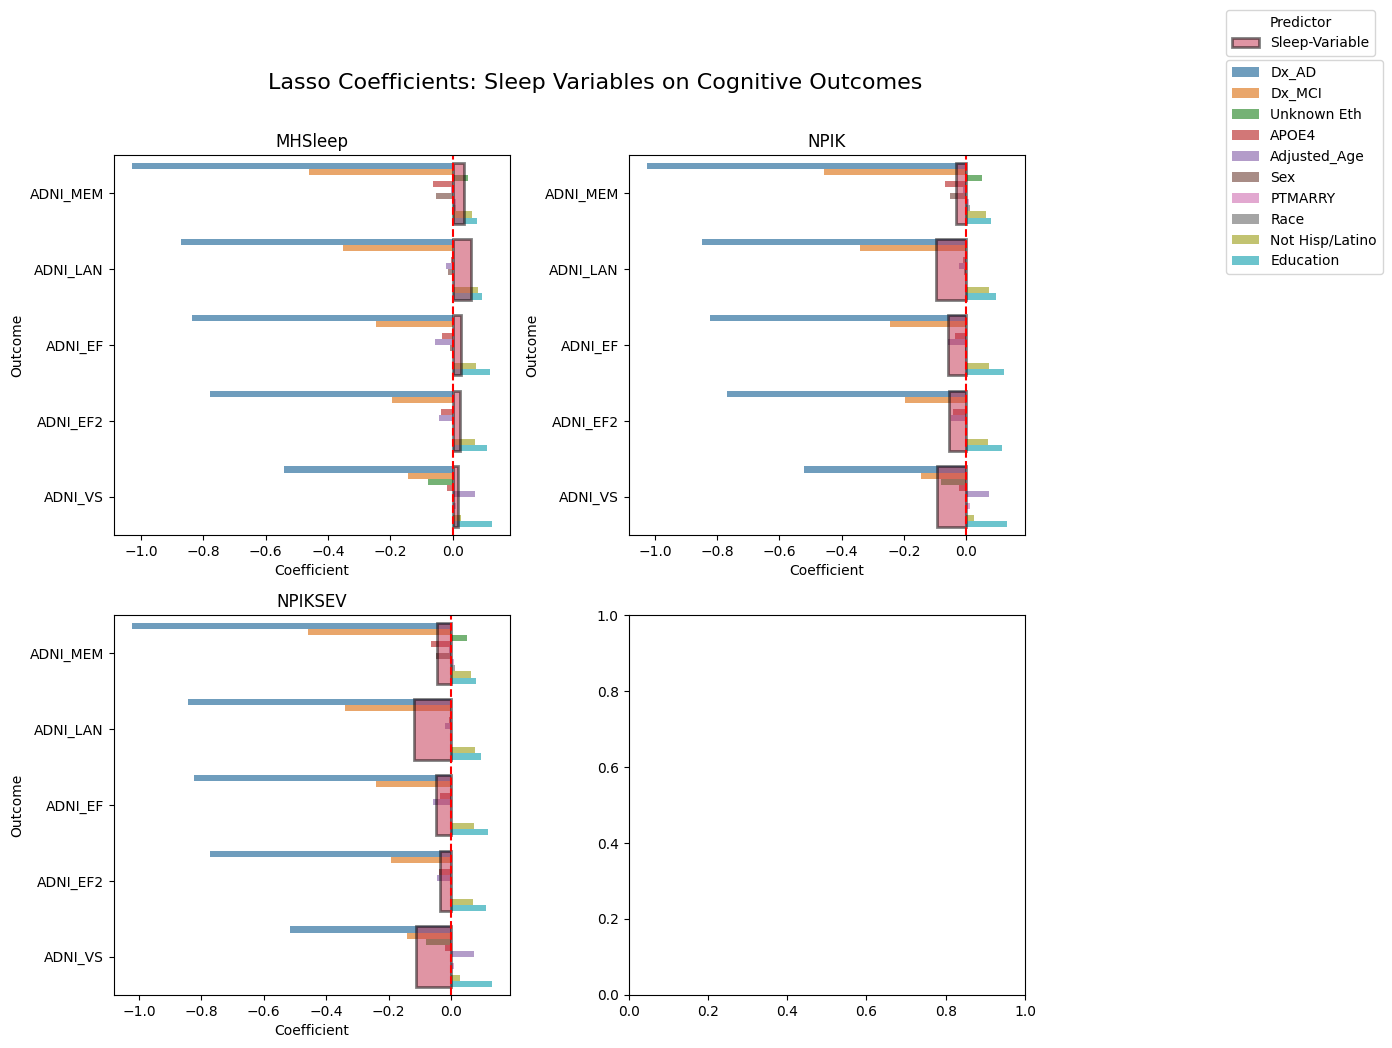

In [26]:
plot_lasso(flat_cog.sort_values(
    by='Coefficient'), domain='Cognitive')

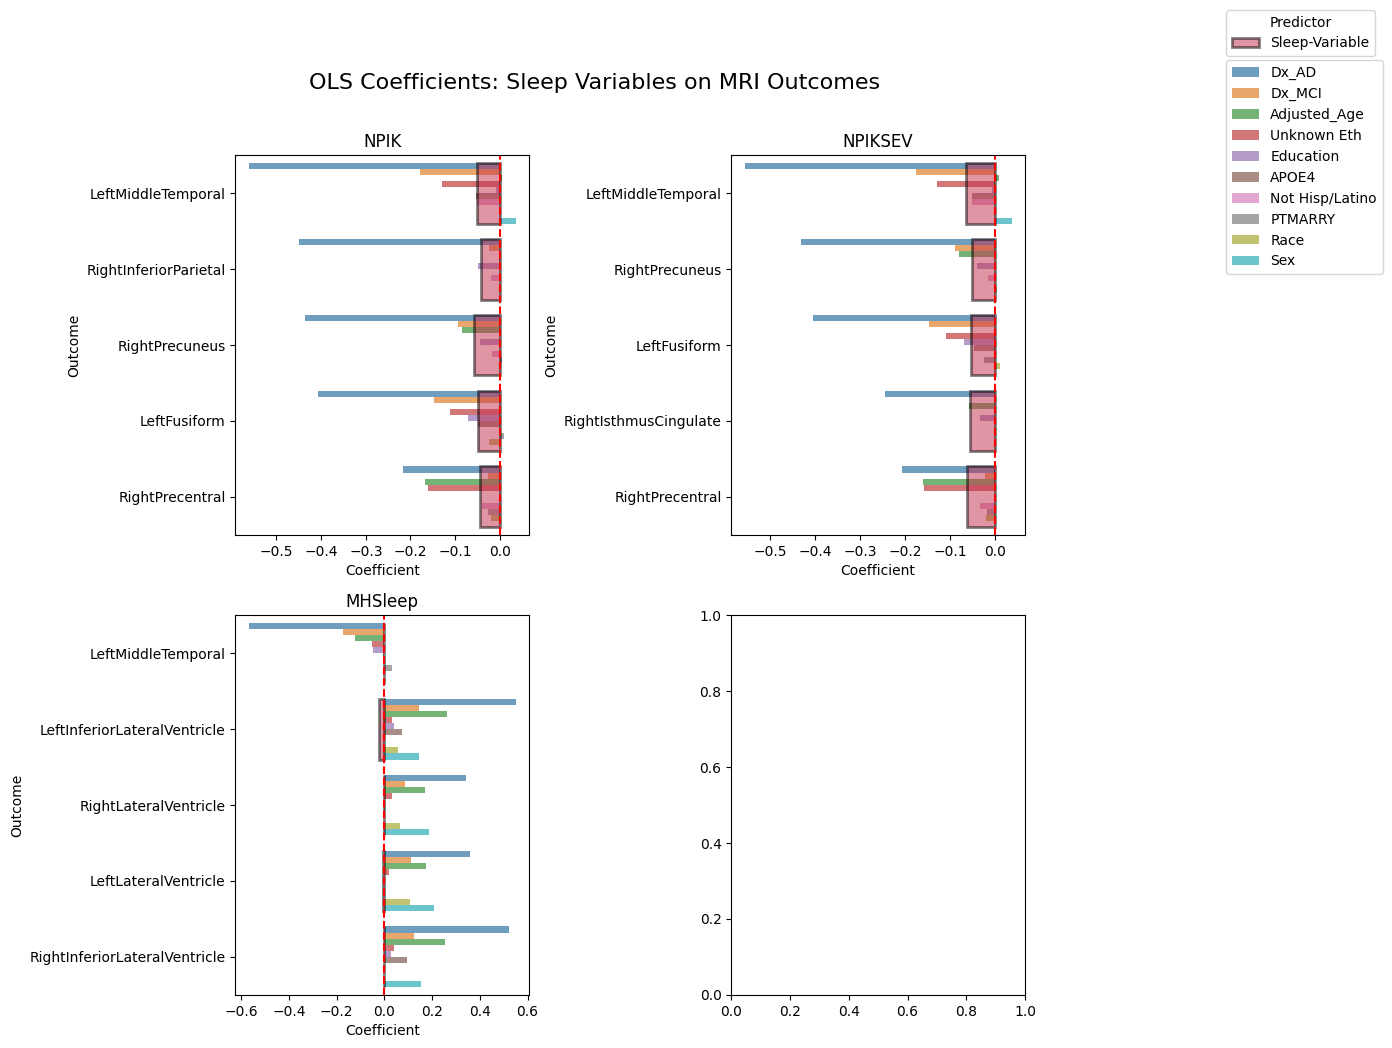

In [20]:
all_df_top = []

for sleep_var in flat_mri['Sleep_Variable'].unique():
    df_plot = flat_mri[(flat_mri['Sleep_Variable'] == sleep_var)]

    top_outcomes = (
        df_plot[(df_plot['Feature'] == sleep_var) ]
        .sort_values(by='Coefficient')
        .set_index('Outcome')['Coefficient']
        .abs()
        .head(5)
        .index
    )
    df_top = df_plot[df_plot['Outcome'].isin(top_outcomes)]
    all_df_top.append(df_top.sort_values(by='Coefficient'))

df_top_all = pd.concat(all_df_top, ignore_index=True)
plot_lasso(df_top_all, domain='MRI')

In [21]:
flat_cog.sort_values(by = "Coefficient", inplace=True)

C:\Users\Dark\AppData\Local\Temp\ipykernel_7288\3473619753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat_cog.sort_values(by = "Coefficient", inplace=True)


In [22]:
summary_rows = []

for sleep_var in flat_cog['Sleep_Variable'].unique():
    for outcome in flat_cog['Outcome'].unique():
        subset = flat_cog[
            (flat_cog['Sleep_Variable'] == sleep_var) &
            (flat_cog['Outcome'] == outcome)
        ]

        if subset.empty:
            continue
        top_neg = subset.nsmallest(3, 'Coefficient')
        for _, row in top_neg.iterrows():
            summary_rows.append({
                'Sleep_Variable': sleep_var,
                'Outcome': outcome,
                'Direction': 'Most Negative',
                'Feature': row['Feature'],
                'Coefficient': row['Coefficient'],
                'P-Value': row['P-Value'],
                'R-Squared': row['R-Squared']
            })
        top_pos = subset.nlargest(3, 'Coefficient')
        for _, row in top_pos.iterrows():
            summary_rows.append({
                'Sleep_Variable': sleep_var,
                'Outcome': outcome,
                'Direction': 'Most Positive',
                'Feature': row['Feature'],
                'Coefficient': row['Coefficient'],
                'P-Value': row['P-Value'],
                'R-Squared': row['R-Squared']
            })

cog_summary_df = pd.DataFrame(summary_rows)
cog_summary_df = cog_summary_df.sort_values(
    by=['Outcome', 'Sleep_Variable', 'Direction'])

In [23]:
cog_summary_df

,Sleep_Variable,Outcome,Direction,Feature,Coefficient,P-Value,R-Squared
12,MHSleep,ADNI_EF,Most Negative,Dx_AD,-0.835991,None,0.529467
13,MHSleep,ADNI_EF,Most Negative,Dx_MCI,-0.247128,None,0.529467
14,MHSleep,ADNI_EF,Most Negative,Adjusted_Age,-0.057921,None,0.529467
15,MHSleep,ADNI_EF,Most Positive,Education,0.120846,None,0.529467
16,MHSleep,ADNI_EF,Most Positive,Not Hisp/Latino,0.075914,None,0.529467
...,...,...,...,...,...,...,...
85,NPIKSEV,ADNI_VS,Most Negative,Dx_MCI,-0.141512,None,0.273293
86,NPIKSEV,ADNI_VS,Most Negative,NPIKSEV,-0.110692,None,0.273293
87,NPIKSEV,ADNI_VS,Most Positive,Education,0.131278,None,0.273293
88,NPIKSEV,ADNI_VS,Most Positive,Adjusted_Age,0.074278,None,0.273293
